# GridSearch Compared
- this notebook tries to compare the performances, computation times and trade offs between the following grid search alternatives:
    1. Exhaustive grid search
    2. halving grid search
    3. randomized grid search
    4. halving randomized grid search

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

### The data
- the data is the data set from Kaggle-Playground-Series-May-2021

In [2]:
# there are 41 features and 1 categorical target variable
path = r"C:\Users\tanch\Documents\GitHub\Kaggle-Playground-Series-May-2021\Input\train.csv\train.csv"
df = pd.read_csv(path,index_col=0)
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,1,0,0,0,0,0,...,0,0,21,0,0,0,0,0,0,Class_2
1,0,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,13,2,0,Class_1
3,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,1,0,Class_4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Class_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,1,0,0,0,2,0,0,...,0,0,6,0,0,3,0,0,0,Class_1
99996,0,0,0,0,0,0,0,1,2,0,...,0,2,0,0,0,10,0,0,0,Class_2
99997,0,0,0,0,0,1,0,0,0,4,...,0,0,0,0,1,0,0,2,0,Class_3


In [3]:
# pre-processing the target variable
target_mapping = {'Class_2':2,
                  'Class_1':1,
                 'Class_3':3,
                 'Class_4':4,}
df.target = df.target.map(target_mapping)

C:\Users\tanch\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

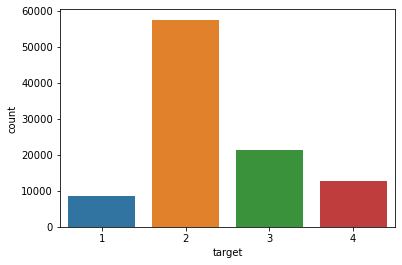

In [4]:
# target variable has 4 classes and appears to be unbalanced 
# majority of labels are class 2 
sb.countplot(df.target)

In [5]:
# all features are integers with finite cardinality, we can consider them categorical
# there are no NAs
def quick_summary(dataframe):
    features = zip(dataframe.dtypes,
                   dataframe.count(),
                   dataframe.isna().sum(),
                   dataframe.min(),
                   dataframe.max(),
                   dataframe.mean(),
                   dataframe.nunique())
    feature_names = ['dtype','non-NA count','NA count','min','max','mean','nunique']
    return pd.DataFrame(list(features),index=df.columns,columns = feature_names)
quick_summary(df)

,dtype,non-NA count,NA count,min,max,mean,nunique
feature_0,int64,100000,0,0,10,0.25783,11
feature_1,int64,100000,0,0,31,0.43172,31
feature_2,int64,100000,0,0,6,0.11413,7
feature_3,int64,100000,0,0,26,0.59055,26
feature_4,int64,100000,0,0,38,0.59977,38
feature_5,int64,100000,0,0,10,0.16082,11
feature_6,int64,100000,0,0,27,0.73149,28
feature_7,int64,100000,0,0,31,1.22892,32
feature_8,int64,100000,0,0,39,0.90335,37
feature_9,int64,100000,0,0,17,0.94012,18


### Preprocessing

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, balanced_accuracy_score, accuracy_score

In [7]:
# we want a separate evaluation set to fairly evaluate the model after searching the best model
devSet, evalSet = train_test_split(df, test_size = 0.3,stratify = df.target)

In [8]:
# split features and target variables
dev_X = devSet.iloc[:,:-1]
dev_y = devSet.target
eval_X = evalSet.iloc[:,:-1]
eval_y = evalSet.target

### Methodology
- we create 2 sets of parameter grids and apply grid searches:
    1. one small with 135 combinations
    2. one large with 13122 combinations
         - this grid will only be trained on randomized grid search and halving randomized grid search because the others take too long

In [9]:
small_param_grid = dict(n_estimators=range(20,101,20),          # 5x3x3x3 = 135 combinations of parameters
                           max_depth=range(3,12,3),
                           min_samples_split=range(2,11,4),
                           class_weight=['balanced', None])
large_param_grid = dict(n_estimators=range(20,101),            # 81x9x9x2 = 13122 combinations
                           max_depth=range(3,12),
                           min_samples_split=range(2,11),
                           class_weight=['balanced', None])
n_iter_small = 30
n_iter_large = 135
scoring = 'neg_log_loss'
cv = 5

In [12]:
# instantiate the model and the grid search methods
clf = RandomForestClassifier(random_state=0)              
GS_list = [
    GridSearchCV(clf,                                  
                param_grid = small_param_grid,                        # small_param_grid has 135 combinations
                refit = True,                          
                scoring = scoring,                    
                cv=cv,
                error_score=0,                                 
                n_jobs=-1) ,
    HalvingGridSearchCV(clf,                                  
                        param_grid = small_param_grid,                  
                        refit = True,                          
                        scoring = scoring,                    
                        cv=cv,
                        error_score=0,
                        n_jobs=-1) ,
    RandomizedSearchCV(clf,                                  
                        param_distributions = small_param_grid, 
                        refit = True,                          
                        scoring = scoring,  
                        n_iter = n_iter_small,
                        cv=cv,
                        error_score=0,
                        n_jobs=-1),
    HalvingRandomSearchCV(clf,                                  
                        param_distributions = small_param_grid, 
                        refit = True,                          
                        scoring = scoring,  
                        n_candidates = n_iter_small,
                        cv=cv,
                        error_score=0,
                        n_jobs=-1) ,
    RandomizedSearchCV(clf,                                  
                        param_distributions = large_param_grid,             # large_param_grid  has 13122 combinations
                        refit = True,                          
                        scoring = scoring, 
                        n_iter = n_iter_large,
                        cv=cv,
                        error_score=0,
                        n_jobs=-1),
    HalvingRandomSearchCV(clf,                                  
                        param_distributions = large_param_grid, 
                        refit = True,                          
                        scoring = scoring,   
                        n_candidates = n_iter_large,
                        cv=cv,
                        error_score=0,
                        n_jobs=-1) 
]

In [13]:
log_loss_scores = []

In [14]:
# run each grid search technique
for gs in GS_list:
    %time gs.fit(dev_X, dev_y)
    pred = gs.predict_proba(eval_X) 
    log_loss_scores.append(log_loss(eval_y, pred))

Wall time: 4min 6s
Wall time: 39.5 s
Wall time: 1min 37s
Wall time: 7.83 s
Wall time: 6min 53s
Wall time: 23.7 s


In [19]:
GS_name_list = ['ExhaustiveGridSearch','HalvingGridSearch','randomGridSearch','halvingRandomGridSearch','randomGridSearch_largeGrid','halvingRandomGridSearch_largeGrid']
time = ['4min 6s','39.5 s','1min 37s','7.83 s','6min 53s','23.7 s']

## Observation
- Comparing the performances on small parameter grid of 135 combinations:
    - both Exhaustive grid search and randomGridSearch performed best , with logloss 1.106986
    - but randomGridSearch required only almost one-third of the time
    - HalvingGridSearch required 1/6 of the time compared to ExhaustiveGridSearch with about 0.003 increase in logloss
    - halvingRandomGridSearch the fastest by a large margin but had about 0.006 increase in logloss
- Comparing performances on large grid of 13122 combinations:
    - randomGridSearch performed better than halvingRandomGridSearch but was considerably slower
    

In [20]:
pd.DataFrame([log_loss_scores,time], 
             columns=GS_name_list,
             index=['logloss','time'])

,ExhaustiveGridSearch,HalvingGridSearch,randomGridSearch,halvingRandomGridSearch,randomGridSearch_largeGrid,halvingRandomGridSearch_largeGrid
logloss,1.106986,1.109734,1.106986,1.113321,1.106043,1.112482
time,4min 6s,39.5 s,1min 37s,7.83 s,6min 53s,23.7 s


# Conclusion:
- RandomGridSearch:
    - in my opinion, is the **clear winner** 
    - it is able to cover a large parameter grid in a **respectable amount of time while producing a decent score** comparable to ExhaustiveGridSearch
- HalvingGridSearch:
    - though is the fastest, by a huge margin, it does lose some performance
    - **if a very large parameter grid needs to be covered**, this could be a better choice because the alternatives may take too long
- ExhaustiveGridSearch:
    - this method will take too long if the parameter grid becomes large
    - however, **if the parameter grid is small** because a developer has a rough idea based on past experience, this might be the better choice